In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from tensorflow.keras.datasets import mnist

from skimage import io, transform, color, filters
from matplotlib import pyplot as plt
from skimage.morphology import disk, ball
from skimage.filters import threshold_otsu

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import glob
from tqdm.notebook import tqdm
import imutils

from numba import jit
import pandas as pd
from scipy.signal import argrelextrema
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.signal import find_peaks


# Handwritten digit classification

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28,28,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# model.summary()

In [132]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_test=x_test.reshape(-1,28,28,1)/255
x_train=x_train.reshape(-1,28,28,1)/255
y_test=tf.keras.utils.to_categorical(y_test)
y_train=tf.keras.utils.to_categorical(y_train)


In [139]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [140]:
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=256),
                              epochs = 20, validation_data = (x_test,y_test),
                              verbose = 1)

Epoch 1/20
235/235 [==============================] - 13s 42ms/step - loss: 1.5697 - accuracy: 0.5491 - val_loss: 1.5646 - val_accuracy: 0.3639
Epoch 2/20
235/235 [==============================] - 10s 42ms/step - loss: 0.2927 - accuracy: 0.9178 - val_loss: 0.1556 - val_accuracy: 0.9513
Epoch 3/20
235/235 [==============================] - 10s 42ms/step - loss: 0.1845 - accuracy: 0.9485 - val_loss: 0.0698 - val_accuracy: 0.9787
Epoch 4/20
235/235 [==============================] - 10s 42ms/step - loss: 0.1402 - accuracy: 0.9611 - val_loss: 0.0624 - val_accuracy: 0.9809
Epoch 5/20
116/235 [=============>................] - ETA: 4s - loss: 0.1248 - accuracy: 0.9662

KeyboardInterrupt: 

In [141]:
# model.save_weights('mnist.h5')

In [4]:
model.load_weights('mnist.h5')

In [5]:
@jit(nopython=True)
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    framed_img = np.ones((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

In [218]:
def crop(gra_f):
    mean_pixel_column=[]
    for j in range(gra_f.shape[1]):
        pixels=[]
        for i in range(gra_f.shape[0]):
            pixels.append(gra_f[i,j])
        mean_pixel_column.append(np.mean(pixels))

    deriv=np.gradient(mean_pixel_column)

    fit1 = SimpleExpSmoothing(deriv).fit(smoothing_level=0.2,optimized=False).fittedvalues

    x_min=find_peaks(fit1,)[0][0]
    x_max=argrelextrema(fit1, np.less)[0][-1]

    return x_min, x_max


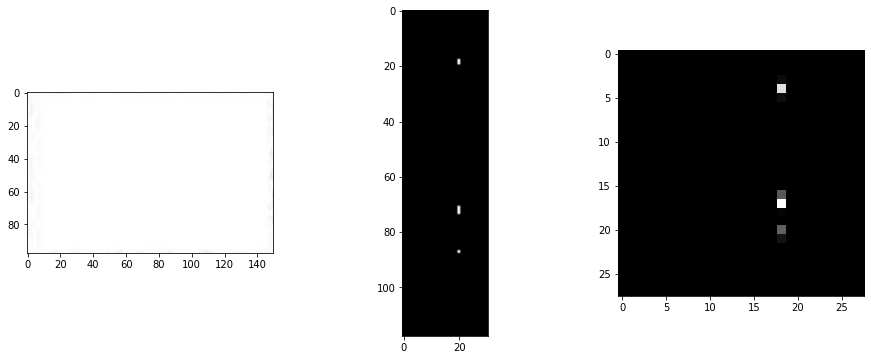

0 0.00010553869
1 0.9908668
2 0.0007007463
3 0.0041849017
4 0.00010166286
5 0.0016113806
6 0.00045752327
7 0.0017981094
8 8.156168e-05
9 9.174774e-05


1

In [220]:
# img=io.imread('4_c.jpg')
img=io.imread('empty_c.jpg')
# img=io.imread('4_c_2.jpg')
# img=io.imread('4_c_2_rect.jpg')
# img=io.imread('4.jpg')
# img=io.imread('3.jpg')
# img=io.imread('3_c.png')
# img=io.imread('5.png')
# img=io.imread('5_c.png')
# img=io.imread('error_c.jpg')

gray=color.rgb2gray(img)

gra_f=np.where(gray>0.9, gray, 0)
gra_f=frame_image(gra_f,10)
gra_f=1-gra_f

thr=threshold_otsu(gra_f)
gra_binary=gra_f>thr

gra_f=np.where(gra_binary==True, gra_f, 0)

y_min, y_max=crop(gra_f)

N=20
y_min=y_min-N
if y_min<0:
    y_min=0

gra_f=gra_f[:, y_min:y_max+N]

img_t=transform.resize(gra_f, (28,28,1))

res=model.predict(tf.expand_dims(img_t,0))

fig,(ax1,ax2, ax3)=plt.subplots(1,3, figsize=(15,6))

ax1.imshow(img)
ax2.imshow(gra_f,cmap='gray')
ax3.imshow(img_t,cmap='gray')

plt.show()
for i in range(len(res[0])):
    print(i,res[0,i])

np.argmax(res)


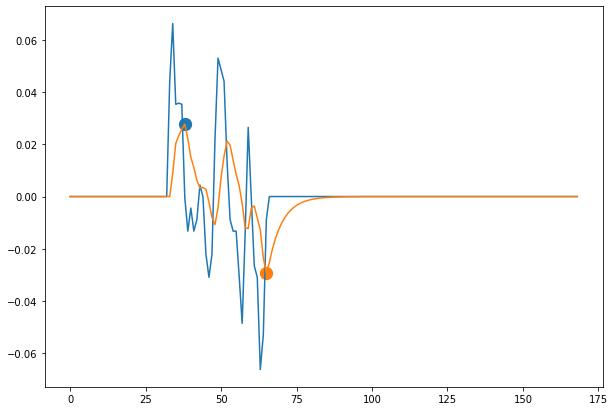

In [213]:
mean_pixel_column=[]
for j in range(gra_f.shape[1]):
    pixels=[]
    for i in range(gra_f.shape[0]):
        pixels.append(gra_f[i,j])
    mean_pixel_column.append(np.mean(pixels))

deriv=np.gradient(mean_pixel_column)

fit1 = SimpleExpSmoothing(deriv).fit(smoothing_level=0.2,optimized=False).fittedvalues


x_min=find_peaks(fit1,)[0][0]
# x_min=argrelextrema(fit1, np.greater)[0][-1]
y_min=fit1[x_min]

# peaks, _ = find_peaks(-fit1,)
peaks= argrelextrema(fit1, np.less)[0]
diffs=np.diff(peaks)

# x_max=peaks[np.where(diffs>15)[0][-1]]
x_max=argrelextrema(fit1, np.less)[0][-1]
y_max=fit1[x_max]


plt.figure(figsize=(10,7))
plt.plot(deriv)
plt.plot(fit1)

plt.scatter(x_min,y_min, s=150)
plt.scatter(x_max,y_max,s=150)


In [206]:
find_peaks(fit1,)[0][0]

38

1 is empty

8 is "проверено"

In [221]:
files_paths=glob.glob('data/blanks_aligned_jpg/*.jpg')
files_paths=[path.replace('\\','/')for path in files_paths]

# save_folder='data/blanks_aligned_jpg/'


preprocess_images=[]

for path in tqdm(files_paths):
    img=io.imread(path)
    img=img[450:561,1162:1321]
    img=img[10:-10, 10:-10]

    gray=color.rgb2gray(img)

    gra_f=np.where(gray>0.9, gray, 0)
    gra_f=frame_image(gra_f,10)
    gra_f=1-gra_f

    thr=threshold_otsu(gra_f)
    gra_binary=gra_f>thr

    gra_f=np.where(gra_binary==True, gra_f, 0)

    y_min, y_max=crop(gra_f)

    N=20
    y_min=y_min-N
    if y_min<0:
        y_min=0

    gra_f=gra_f[:, y_min:y_max+N]

    img_t=transform.resize(gra_f, (28,28,1))

    preprocess_images.append(img_t)

  0%|          | 0/8421 [00:00<?, ?it/s]

In [222]:
grades=[]

for img in tqdm(preprocess_images):
    res=model.predict(tf.expand_dims(img,0))
    grade=np.argmax(res)

    grades.append(grade)

  0%|          | 0/8421 [00:00<?, ?it/s]

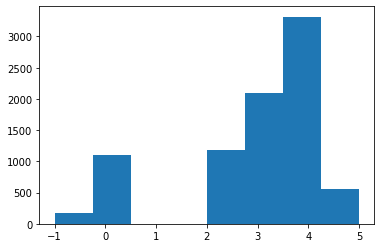

In [263]:
grades_new=[]

for grade in grades:
    if grade==1:
        grades_new.append(-1)
    elif grade>5:
        grades_new.append(0)
    else:
        grades_new.append(grade)

plt.hist(grades_new, bins=8)
plt.xticks(range(-1,6))
plt.show()

In [261]:
files_names=[path.split('/')[-1] for path in files_paths]
df=pd.DataFrame({'file_name':files_names, 'grade':grades_new})

df.to_csv('file_names_grades.csv', index=False)